<a href="https://colab.research.google.com/github/ricardogr07/trabajo-final-series-tiempo/blob/main/src/ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Correr desde Colab
!git clone https://github.com/ricardogr07/trabajo-final-series-tiempo.git
%cd trabajo-final-series-tiempo/src
!ls

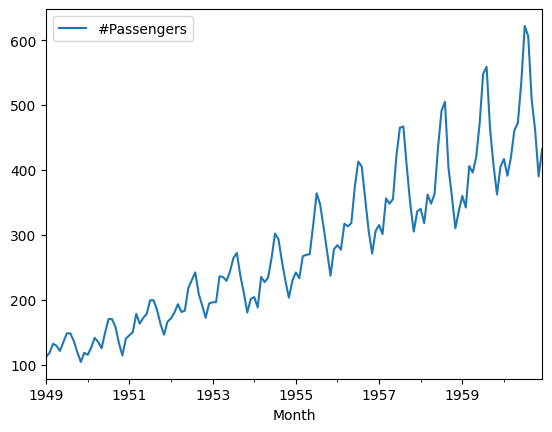

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("../dataset/AirPassengers.csv", parse_dates=["Month"], index_col="Month")
df.plot()
plt.show()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


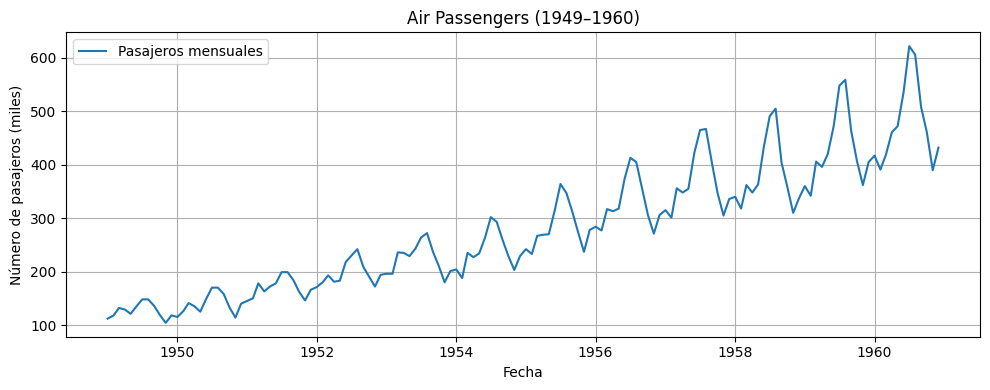

In [ ]:
# Mostrar primeras filas
print(df.head())

# Graficar la serie
plt.figure(figsize=(10, 4))
plt.plot(df, label="Pasajeros mensuales")
plt.title("Air Passengers (1949–1960)")
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros (miles)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(df.describe())
print(df.info())
print("Datos nulos:\n", df.isnull().sum())
print("Duplicados:\n", df.duplicated().sum())

duplicados = df[df.duplicated()]
print(duplicados)

df = df[~df.duplicated()]

       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None
Datos nulos:
 #Passengers    0
dtype: int64
Duplicados:
 26
            #Passengers
Month                  
1949-08-01          148
1949-12-01          118
1950-04-01          135
1950-08-01          170
1951-06-01          178
1951-08-01          199
1952-11-01          172
1953-02-01          196
1953-11-01          180
1954-03-01          235
1954-06-01          264
1954-10-01          229
1954-12-01          229
1955-01-01          242
1955-11-01          237
1956-12-01          306
1957-01-01          315
1957-05-01          355
195

C:\Users\ricar\AppData\Local\Temp\ipykernel_2420\4146186126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_mean_12'] = df['#Passengers'].rolling(window=12).mean()


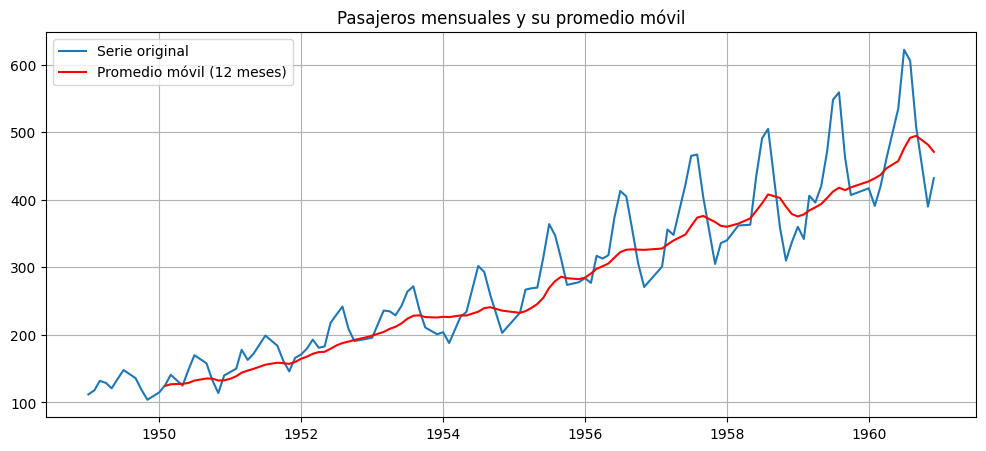

In [ ]:
import seaborn as sns

# Descomposición visual simple (rolling mean)
df['rolling_mean_12'] = df['#Passengers'].rolling(window=12).mean()

plt.figure(figsize=(12, 5))
plt.plot(df['#Passengers'], label='Serie original')
plt.plot(df['rolling_mean_12'], label='Promedio móvil (12 meses)', color='red')
plt.title('Pasajeros mensuales y su promedio móvil')
plt.legend()
plt.grid(True)
plt.show()

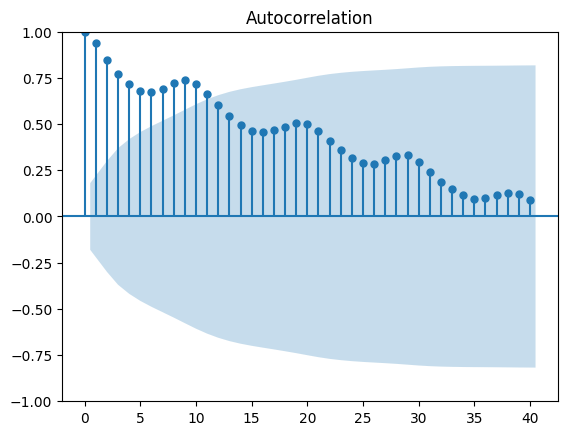

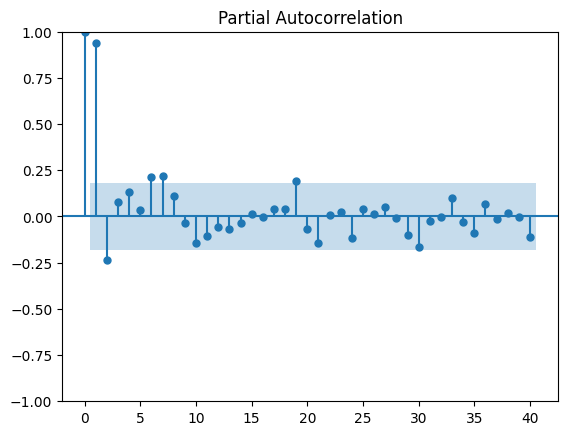

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['#Passengers'], lags=40)
plt.show()

plot_pacf(df['#Passengers'], lags=40)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['#Passengers'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie NO es estacionaria.")

ADF Statistic: 1.0318616091317108
p-value: 0.9945910049958911
La serie NO es estacionaria.


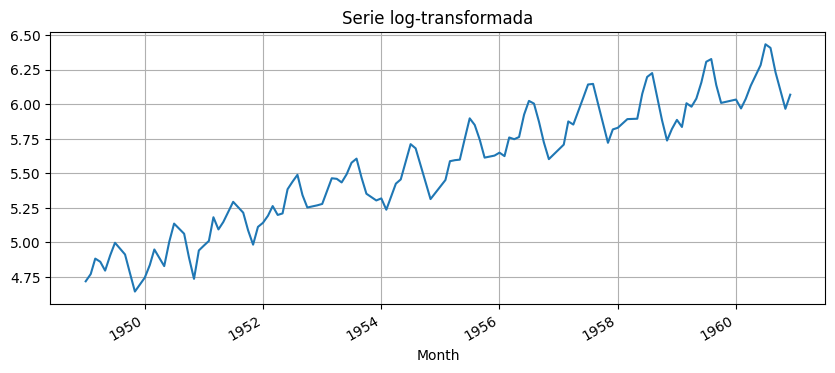

In [ ]:
import numpy as np

df['log_passengers'] = np.log(df['#Passengers'])

df['log_passengers'].plot(title="Serie log-transformada", figsize=(10, 4))
plt.grid(True)
plt.show()

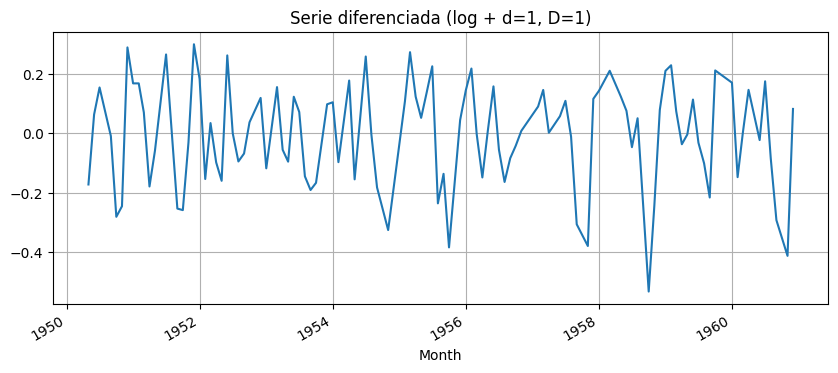

In [ ]:
# Diferencia regular
df['diff1'] = df['log_passengers'].diff()

# Diferencia estacional (12 meses)
df['diff12'] = df['log_passengers'].diff(12)

# Ambas (combinada)
df['diff_comb'] = df['diff12'].diff()

df['diff_comb'].dropna().plot(title="Serie diferenciada (log + d=1, D=1)", figsize=(10, 4))
plt.grid(True)
plt.show()

In [ ]:
result_diff = adfuller(df['diff_comb'].dropna())
print(f'ADF Statistic (d=1, D=1): {result_diff[0]}')
print(f'p-value: {result_diff[1]}')

if result_diff[1] < 0.05:
    print("La serie transformada es estacionaria.")
else:
    print("La serie transformada NO es estacionaria.")

ADF Statistic (d=1, D=1): -3.5029430667210297
p-value: 0.007911830793291498
La serie transformada es estacionaria.


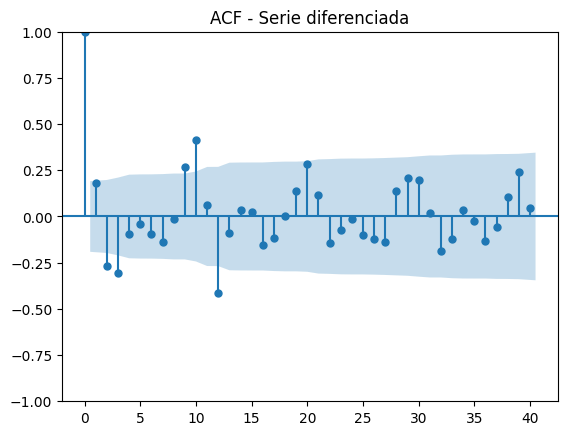

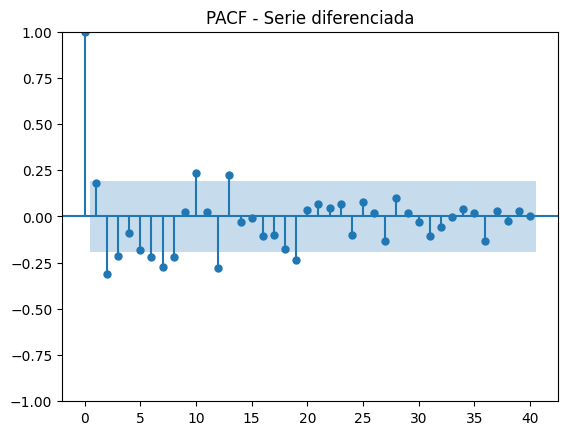

In [ ]:
plot_acf(df['diff_comb'].dropna(), lags=40)
plt.title("ACF - Serie diferenciada")
plt.show()

plot_pacf(df['diff_comb'].dropna(), lags=40)
plt.title("PACF - Serie diferenciada")
plt.show()

In [ ]:
# Diccionario de modelos candidatos a comparar
# Cada entrada es: "nombre": (p,d,q, P,D,Q)

modelos = {
    # Modelo recomendado base: capta patrones locales y estacionalidad anual.
    # Justificación: ACF y PACF muestran componentes AR y MA simples, y P=1 captura estacionalidad clara.
    "M1": (1,1,1, 1,1,0),

    # Modelo más simple (parsimonioso), inspirado en Holt-Winters multiplicativo.
    # Justificación: elimina componente AR y Q estacional. Útil como baseline.
    "M2": (0,1,1, 1,1,0),

    # Modelo con más énfasis en autoregresión.
    # Justificación: PACF muestra posible corte en lag 2. Sin componente MA.
    "M3": (2,1,0, 1,1,0),

    # Variante con componente estacional completo (AR + MA estacional).
    # Justificación: AR en corto plazo + MA estacional posible (ligero pico en lag 12).
    "M4": (1,1,0, 1,1,1),

    # Variante con AR y MA no estacionales + MA estacional (en lugar de AR estacional).
    # Justificación: alternativa estructural, válida si ACF en lag 12 tiene presencia.
    "M5": (1,1,1, 0,1,1),

    # Modelo más completo: incluye todos los componentes.
    # Justificación: para evaluar si el aumento en complejidad mejora sustancialmente el AIC.
    "M6": (1,1,1, 1,1,1),

    # Modelo mínimo clásico (0,1,1)(0,1,1)[12].
    # Justificación: equivalente a Holt-Winters multiplicativo, ampliamente usado.
    "M7": (0,1,1, 0,1,1),

    # Modelo complejo (más flexible) con más parámetros.
    # Justificación: útil como referencia para evaluar sobreajuste en comparación con modelos simples.
    "M8": (2,1,2, 1,1,1)
}

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

resultados = []

for nombre, (p,d,q, P,D,Q) in modelos.items():
    try:
        modelo = SARIMAX(df['log_passengers'],
                         order=(p,d,q),
                         seasonal_order=(P,D,Q,12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
        resultado = modelo.fit(disp=False)

        resultados.append({
            "Modelo": nombre,
            "order": f"({p},{d},{q})({P},{D},{Q})[12]",
            "AIC": resultado.aic,
            "BIC": resultado.bic,
            "LogL": resultado.llf
        })
    except Exception as e:
        print(f"Error en modelo {nombre}: {e}")

df_resultados = pd.DataFrame(resultados).sort_values("AIC")
print(df_resultados.to_string(index=False))

c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

Modelo              order         AIC         BIC      LogL
    M8 (2,1,2)(1,1,1)[12] -123.693774 -106.195106 68.846887
    M7 (0,1,1)(0,1,1)[12] -104.999149  -97.466570 55.499574
    M5 (1,1,1)(0,1,1)[12] -103.000161  -92.956723 55.500080
    M6 (1,1,1)(1,1,1)[12]  -93.193467  -80.639170 51.596734
    M4 (1,1,0)(1,1,1)[12]  -91.763047  -81.675893 49.881524
    M3 (2,1,0)(1,1,0)[12]  -89.030194  -78.986756 48.515097
    M2 (0,1,1)(1,1,0)[12]  -87.621261  -80.023462 46.810630
    M1 (1,1,1)(1,1,0)[12]  -85.113474  -75.026320 46.556737


Mejor modelo: M8 (2,1,2)(1,1,1)[12]


c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


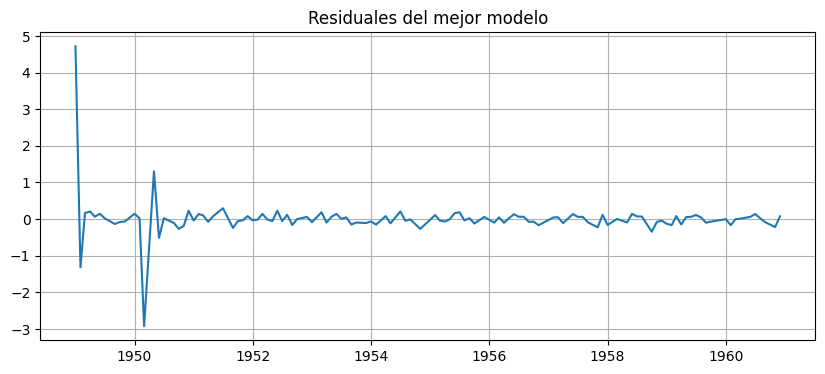

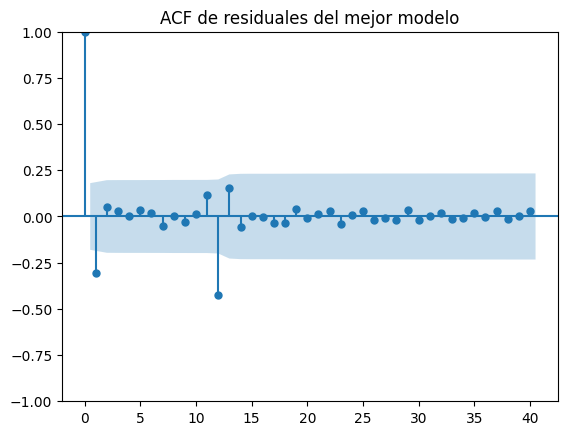

In [ ]:
# Elegir modelo con menor AIC
mejor_modelo = df_resultados.iloc[0]
print("Mejor modelo:", mejor_modelo['Modelo'], mejor_modelo['order'])

import re

# Extraer los dos grupos de parámetros (p,d,q) y (P,D,Q)
orden = mejor_modelo['order']
match = re.findall(r'\((\d+),(\d+),(\d+)\)', orden)

# Convertir a enteros
(p,d,q), (P,D,Q) = [tuple(map(int, grupo)) for grupo in match]

# Ajustar nuevamente para extraer residuos
modelo_best = SARIMAX(df['log_passengers'],
                      order=(p,d,q),
                      seasonal_order=(P,D,Q,12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
resultado_best = modelo_best.fit(disp=False)

# Plot residuos
resid = resultado_best.resid
plt.figure(figsize=(10, 4))
plt.plot(resid)
plt.title("Residuales del mejor modelo")
plt.grid(True)
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(resid, lags=40)
plt.title("ACF de residuales del mejor modelo")
plt.show()

c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

MAE: 96.0
RMSE: 111.03


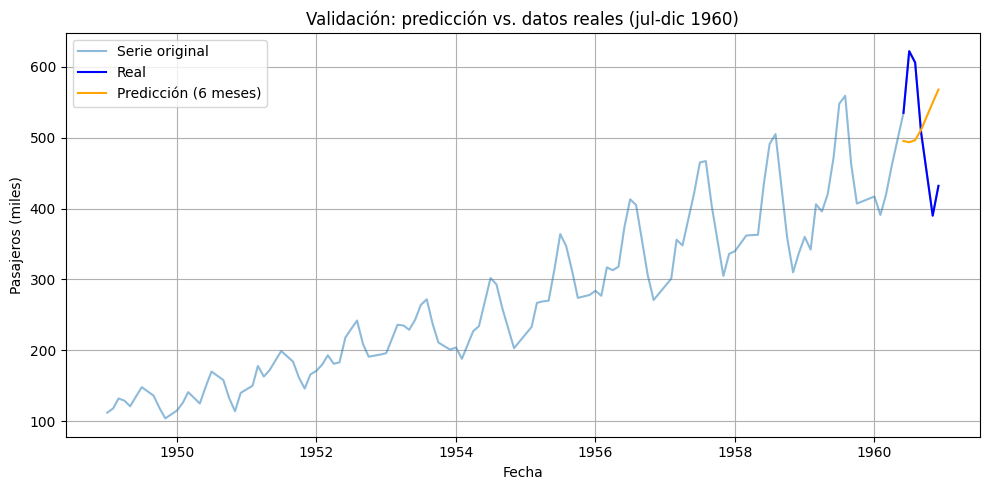

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Recortar últimos 6 meses
df_train = df.iloc[:-6]
df_test = df.iloc[-6:]

# 2. Reentrenar modelo con datos hasta junio 1960
modelo_val = SARIMAX(df_train["log_passengers"],
                     order=(0,1,1),
                     seasonal_order=(0,1,1,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
resultado_val = modelo_val.fit()

# 3. Predicción a 6 meses
pred_val = resultado_val.get_forecast(steps=6)
pred_mean_log = pred_val.predicted_mean
pred_mean = np.exp(pred_mean_log)

# 4. Evaluación
y_true = df_test["#Passengers"].values
y_pred = pred_mean.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

# 5. Visualización
fechas_test = df_test.index

plt.figure(figsize=(10,5))
plt.plot(df["#Passengers"], label="Serie original", alpha=0.5)
plt.plot(fechas_test, y_true, label="Real", color='blue')
plt.plot(fechas_test, y_pred, label="Predicción (6 meses)", color='orange')
plt.title("Validación: predicción vs. datos reales (jul-dic 1960)")
plt.xlabel("Fecha")
plt.ylabel("Pasajeros (miles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


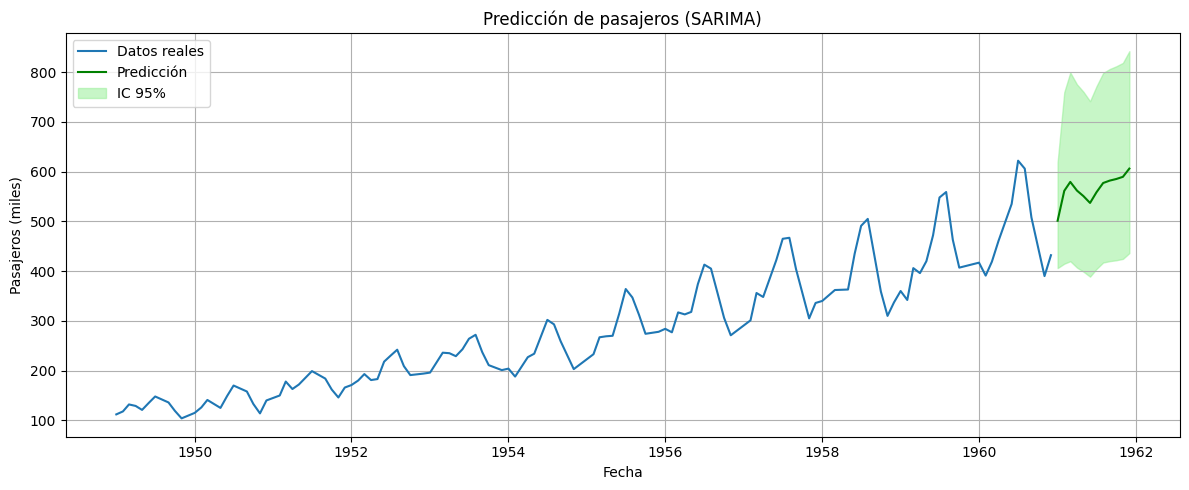

            Predicción  IC 95% Inferior  IC 95% Superior
Fecha                                                   
1961-01-01      501.31           406.10           618.85
1961-02-01      561.42           414.92           759.64
1961-03-01      579.32           419.93           799.20
1961-04-01      561.92           407.21           775.40
1961-05-01      550.88           398.98           760.60
1961-06-01      537.03           388.91           741.58
1961-07-01      558.54           404.37           771.49
1961-08-01      577.14           417.28           798.23
1961-09-01      581.99           420.09           806.28
1961-10-01      585.15           421.83           811.70
1961-11-01      589.54           424.62           818.52
1961-12-01      606.10           436.24           842.10


In [ ]:
# Número de pasos a predecir (12 meses)
n_steps = 12

# Obtener predicción
pred = resultado_best.get_forecast(steps=n_steps)

# Recuperar intervalos en escala log
pred_ci = pred.conf_int()

# Transformar de log a escala original
pred_mean = np.exp(pred.predicted_mean)
ci_lower = np.exp(pred_ci.iloc[:, 0])
ci_upper = np.exp(pred_ci.iloc[:, 1])

# Construir fechas futuras
last_date = df.index[-1]
futuras_fechas = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Graficar serie original + predicción + intervalos
plt.figure(figsize=(12,5))
plt.plot(df.index, df['#Passengers'], label='Datos reales')
plt.plot(futuras_fechas, pred_mean, label='Predicción', color='green')
plt.fill_between(futuras_fechas, ci_lower, ci_upper, color='lightgreen', alpha=0.5, label='IC 95%')
plt.title("Predicción de pasajeros (SARIMA)")
plt.xlabel("Fecha")
plt.ylabel("Pasajeros (miles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Construir tabla con predicciones
tabla_pred = pd.DataFrame({
    "Fecha": futuras_fechas,
    "Predicción": pred_mean.values,
    "IC 95% Inferior": ci_lower.values,
    "IC 95% Superior": ci_upper.values
})
tabla_pred.set_index("Fecha", inplace=True)

# Mostrar tabla
print(tabla_pred.round(2))